In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import numpy as np

from scipy.stats import mode 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_samples, silhouette_score

import math

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
data_dir = '../../../data/processed/Distrito_QRO/'

In [3]:
# hex_cluster = gpd.read_file('../data/processed/hex_clusters.geojson')

In [4]:
# hex_cluster.groupby('cluster').agg(['mean','median','std','count']).to_csv('../data/processed/cluster_stats.csv')

In [5]:
# hex_cluster.groupby('cluster').agg('mean','median','std').to_csv('../data/processed/cluster_stats_mean.csv')

In [6]:
hex_socio = gpd.read_file(f'{data_dir}hex_sociodemographic.geojson')
hex_eco = gpd.read_file(f'{data_dir}hex_economic.geojson')
hex_infra = gpd.read_file(f'{data_dir}hex_infraestructura.geojson')
hex_env = gpd.read_file(f'{data_dir}hex_environmental.geojson')
# hex_con = gpd.read_file(f'{data_dir}hex_connectivity.geojson')
hex_us = gpd.read_file(f'{data_dir}hex_urban_structure.geojson')
hex_prox = gpd.read_file(f'{data_dir}hex_proximity.geojson')

## Data treatment

In [7]:
hex_gdf = hex_eco[['hex_id_9','geometry']].copy()
print(hex_gdf.shape)
hex_gdf.head(2)

(2826, 2)


,hex_id_9,geometry
0,8949822402fffff,"POLYGON ((-100.2089 20.74718, -100.20765 20.74..."
1,89498224103ffff,"POLYGON ((-100.22424 20.75045, -100.223 20.752..."


#### Filter

In [8]:
# hex_filter = gpd.read_file(f'{data_dir}hex_filter.geojson')
# hex_gdf = hex_gdf.loc[hex_gdf.hex_id_9.isin(list(hex_filter.hex_id_9.unique()))]
# print(hex_gdf.shape)
# hex_gdf.head(2)

#### Spatial filter

In [9]:
gdf = gpd.read_file(f'{data_dir}PoligonoEstudio_DistritoQRO_GCS_v1.geojson')
gdf['geometry'] = gdf.to_crs("EPSG:32614").buffer(1500)
gdf = gdf.to_crs("EPSG:4326")
hex_clip = gpd.clip(hex_gdf, gdf)
hex_gdf = hex_gdf.loc[hex_gdf.hex_id_9.isin(list(hex_clip.hex_id_9.unique()))]
print(hex_gdf.shape)
hex_gdf.head(2)

(351, 2)


,hex_id_9,geometry
474,894983c120bffff,"POLYGON ((-100.43583 20.61766, -100.43459 20.6..."
478,894983c121bffff,"POLYGON ((-100.43624 20.61428, -100.435 20.615..."


In [10]:
hex_socio = hex_socio.loc[hex_socio.hex_id_9.isin(list(hex_gdf.hex_id_9))].copy()
hex_eco = hex_eco.loc[hex_eco.hex_id_9.isin(list(hex_gdf.hex_id_9))].copy()
hex_infra = hex_infra.loc[hex_infra.hex_id_9.isin(list(hex_gdf.hex_id_9))].copy()
hex_env = hex_env.loc[hex_env.hex_id_9.isin(list(hex_gdf.hex_id_9))].copy()
# hex_con = gpd.read_file(f'{data_dir}hex_connectivity.geojson')
hex_us = hex_us.loc[hex_us.hex_id_9.isin(list(hex_gdf.hex_id_9))].copy()
hex_prox = hex_prox.loc[hex_prox.hex_id.isin(list(hex_gdf.hex_id_9))].copy()

### Sociodemographic

In [11]:
hex_socio.head(2)

,hex_id_9,CVEGEO,NOMGEO,city,type,nse_idx,hex_id,graproes,dens_pob_ha,auto_viv,pct_0_17,pct_18_59,pct_60_mas,wgt_imn,geometry
1031,894983c164fffff,22014,Querétaro,Queretaro,urban,0.719938,894983c164fffff,13.370000,121.525788,0.747792,0.228204,0.682472,0.089324,0.982589,"POLYGON ((-100.43209 20.59674, -100.43084 20.5..."
1032,894983ca69bffff,22014,Querétaro,Queretaro,urban,-0.291936,894983ca69bffff,10.579962,74.240933,0.421820,0.234698,0.593994,0.171307,0.953263,"POLYGON ((-100.37653 20.58776, -100.37528 20.5..."


In [12]:
hex_socio = hex_socio[['hex_id_9','nse_idx','graproes',
                       'dens_pob_ha',
                       'auto_viv','pct_0_17','pct_18_59',
                       'pct_60_mas','wgt_imn']]
socio_cols = ['nse_idx',
              'graproes','dens_pob_ha',
                       'auto_viv','pct_0_17','pct_18_59',
                       'pct_60_mas','wgt_imn']
hex_socio = hex_socio.fillna(0)
hex_socio_std = hex_socio.copy()
hex_socio_std[socio_cols] = StandardScaler().fit_transform(np.array(hex_socio[socio_cols]))
print(hex_socio_std.shape)
hex_socio_std.head(2)

(351, 9)


,hex_id_9,nse_idx,graproes,dens_pob_ha,auto_viv,pct_0_17,pct_18_59,pct_60_mas,wgt_imn
1031,894983c164fffff,0.757222,0.550993,1.651415,0.721618,0.093373,0.609432,-0.949456,0.296752
1032,894983ca69bffff,-0.723560,-0.325650,0.516722,-0.912293,0.140892,0.010011,0.141096,0.146848


In [13]:
pca = PCA(n_components=3)

x = hex_socio_std.loc[:, socio_cols].values

principalComponents = pca.fit_transform(x)

In [14]:
print('Explained ratio:',pca.explained_variance_ratio_,'Explained variance:',pca.explained_variance_ratio_.sum())

Explained ratio: [0.59510502 0.1584583  0.10080339] Explained variance: 0.8543667065714887


In [15]:
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc_1', 'pc_2','pc_3'])

hex_socio_pca = hex_socio[['hex_id_9']]
hex_socio_pca.loc[:,['socio_pc_1','socio_pc_2','socio_pc_3']]= np.nan, np.nan, np.nan
hex_socio_pca.loc[:,'socio_pc_1'] = principalDf['pc_1'].copy()
hex_socio_pca.loc[:,'socio_pc_2'] = principalDf['pc_2'].copy()
hex_socio_pca.loc[:,'socio_pc_3'] = principalDf['pc_3'].copy()

### Economic

In [16]:
hex_eco.head(2)

,hex_id_9,denue_count,denue_jobs,denue_0_5,denue_6_10,denue_11_30,denue_31_50,denue_51_100,denue_101_250,denue_250_mas,denue_jobs_>_11,pct_jobs_>_11,Comercio,Gubernamental,Industria,Otros,Servicios,per_ocu_tot,geometry
474,894983c120bffff,2913.015873,28336.079365,2408.190476,204.285714,173.380952,46.698413,31.746032,27.142857,21.571429,19477.222222,0.687365,0.000000,0.072254,0.905588,0.010597,0.011561,1038.0,"POLYGON ((-100.43583 20.61766, -100.43459 20.6..."
478,894983c121bffff,3237.383838,29026.969697,2715.161616,220.393939,177.333333,47.151515,31.343434,24.101010,21.898990,19118.333333,0.658640,0.554854,0.000000,0.063141,0.086030,0.295975,1267.0,"POLYGON ((-100.43624 20.61428, -100.435 20.615..."


In [17]:
hex_eco = hex_eco[['hex_id_9','denue_count','denue_jobs','denue_jobs_>_11',
                   'pct_jobs_>_11',]]
eco_cols = ['denue_count','denue_jobs','denue_jobs_>_11',
                   'pct_jobs_>_11']
hex_eco = hex_eco.fillna(0)
hex_eco_std = hex_eco.copy()
hex_eco_std[eco_cols] = StandardScaler().fit_transform(np.array(hex_eco[eco_cols]))
print(hex_eco_std.shape)
hex_eco_std.head(2)

(351, 5)


,hex_id_9,denue_count,denue_jobs,denue_jobs_>_11,pct_jobs_>_11
474,894983c120bffff,-0.175624,-0.118862,-0.046436,0.196963
478,894983c121bffff,-0.058235,-0.085673,-0.075524,-0.117070


In [18]:
pca = PCA(n_components=2)

x = hex_eco_std.loc[:, eco_cols].values

principalComponents = pca.fit_transform(x)

In [19]:
print('Explained ratio:',pca.explained_variance_ratio_,'Explained variance:',pca.explained_variance_ratio_.sum())

Explained ratio: [0.76746852 0.22498457] Explained variance: 0.9924530843990437


In [20]:
hex_eco_pca = hex_eco[['hex_id_9']]
hex_eco_pca.loc[:,['eco_pc_1','eco_pc_2',]] = np.nan, np.nan,
hex_eco_pca.loc[:,'eco_pc_1'] = principalComponents[:,0]
hex_eco_pca.loc[:,'eco_pc_2'] = principalComponents[:,1]

### Infraestructure

In [21]:
hex_infra.head(2)

,hex_id_9,CVEGEO,NOMGEO,city,type,pct_BANQUETA,pct_ALUMPUB,pct_RAMPAS,pct_ARBOLES,pct_CICLOVIA,geometry
1031,894983c164fffff,22014,Querétaro,Queretaro,urban,1.000000,0.568418,0.036509,0.747081,0.031373,"POLYGON ((-100.43209 20.59674, -100.43084 20.5..."
1032,894983ca69bffff,22014,Querétaro,Queretaro,urban,0.902017,0.896248,0.308897,0.387534,0.139579,"POLYGON ((-100.37653 20.58776, -100.37528 20.5..."


In [22]:
hex_infra = hex_infra[['hex_id_9','pct_BANQUETA','pct_ALUMPUB',
                      'pct_RAMPAS','pct_ARBOLES','pct_CICLOVIA']]
infra_cols = ['pct_BANQUETA','pct_ALUMPUB',
                      'pct_RAMPAS','pct_ARBOLES','pct_CICLOVIA']
hex_infra = hex_infra.fillna(0)
hex_infra_std = hex_infra.copy()
hex_infra_std[infra_cols] = StandardScaler().fit_transform(np.array(hex_infra[infra_cols]))
print(hex_infra_std.shape)
hex_infra_std.head(2)

(351, 6)


,hex_id_9,pct_BANQUETA,pct_ALUMPUB,pct_RAMPAS,pct_ARBOLES,pct_CICLOVIA
1031,894983c164fffff,0.661625,-0.070892,-0.676883,0.552648,-0.045390
1032,894983ca69bffff,0.240337,1.353146,0.506859,-0.810104,1.223511


In [23]:
pca = PCA(n_components=3)

x = hex_infra_std.loc[:, infra_cols].values

principalComponents = pca.fit_transform(x)

In [24]:
print('Explained ratio:',pca.explained_variance_ratio_,'Explained variance:',pca.explained_variance_ratio_.sum())

Explained ratio: [0.42552492 0.2374762  0.13938278] Explained variance: 0.8023839076362147


In [25]:
hex_infra_pca = hex_infra[['hex_id_9']]
hex_infra_pca.loc[:,['infra_pc_1','infra_pc_2','infra_pc_3']]= np.nan, np.nan, np.nan
hex_infra_pca.loc[:,'infra_pc_1'] = principalComponents[:,0].copy()
hex_infra_pca.loc[:,'infra_pc_2'] = principalComponents[:,1].copy()
hex_infra_pca.loc[:,'infra_pc_2'] = principalComponents[:,2].copy()

### Environment

In [26]:
hex_env.head(2)

,hex_id_9,CVEGEO,NOMGEO,city,type,ndvi_mean,area_m2,area_pob,hex_id,temp_diff_mean,geometry
1031,894983c164fffff,22014,Querétaro,Queretaro,urban,0.091783,10030.620982,4.893145,894983c164fffff,0.821974,"POLYGON ((-100.43209 20.59674, -100.43084 20.5..."
1032,894983ca69bffff,22014,Querétaro,Queretaro,urban,0.109029,5013.192544,2.541095,894983ca69bffff,0.555770,"POLYGON ((-100.37653 20.58776, -100.37528 20.5..."


In [27]:
hex_env = hex_env[['hex_id_9','ndvi_mean','temp_diff_mean',
                   'area_m2',]]
env_cols = ['ndvi_mean','area_m2','temp_diff_mean']
hex_env = hex_env.fillna(0)
hex_env_std = hex_env.copy()
hex_env_std[env_cols] = StandardScaler().fit_transform(np.array(hex_env[env_cols]))
print(hex_env_std.shape)
hex_env_std.head(2)

(351, 4)


,hex_id_9,ndvi_mean,temp_diff_mean,area_m2
1031,894983c164fffff,-0.964994,0.618612,-0.407836
1032,894983ca69bffff,-0.686582,0.424056,-0.624757


In [28]:
num_comp = 2
pca = PCA(n_components=num_comp)

x = hex_env_std.loc[:, env_cols].values

principalComponents = pca.fit_transform(x)

In [29]:
print('Explained ratio:',pca.explained_variance_ratio_,'Explained variance:',pca.explained_variance_ratio_.sum())

Explained ratio: [0.57953732 0.25145957] Explained variance: 0.8309968909202519


In [30]:
hex_env_pca = hex_env[['hex_id_9']]

for nc in range(num_comp):
    hex_env_pca.loc[:,[f'us_pc_{nc+1}']] = np.nan
    hex_env_pca.loc[:,f'us_pc_{nc+1}'] = principalComponents[:,nc].copy()

### Connectivity

In [33]:
hex_con = hex_con[['hex_id_9','dist_ciclo','ruta_count',
                  'dist_tp','dist_tpm']]
conn_cols = ['dist_ciclo','ruta_count',
                  'dist_tp','dist_tpm']
hex_con = hex_con.fillna(0)
hex_con_std = hex_con.copy()
hex_con_std[conn_cols] = StandardScaler().fit_transform(np.array(hex_con[conn_cols]))
print(hex_con_std.shape)
hex_con_std.head(2)

NameError: name 'hex_con' is not defined

In [30]:
pca = PCA(n_components=2)

x = hex_con_std.loc[:, conn_cols].values

principalComponents = pca.fit_transform(x)

NameError: name 'hex_con_std' is not defined

In [22]:
print('Explained ratio:',pca.explained_variance_ratio_,'Explained variance:',pca.explained_variance_ratio_.sum())

Explained ratio: [0.52776501 0.28335031] Explained variance: 0.8111153169189178


In [23]:
hex_con_pca = hex_con[['hex_id_9']]
hex_con_pca.loc[:,'conn_pc_1'] = principalComponents[:,0].copy()
hex_con_pca.loc[:,'conn_pc_2'] = principalComponents[:,1].copy()

/tmp/ipykernel_50183/986357026.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hex_con_pca.loc[:,'conn_pc_1'] = principalComponents[:,0].copy()
/tmp/ipykernel_50183/986357026.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hex_con_pca.loc[:,'conn_pc_2'] = principalComponents[:,1].copy()


### Urban structure

In [31]:
hex_us.head(2)

,hex_id_9,CVEGEO,NOMGEO,city,type,pct_comerciomean,pct_equipmean,pct_habmean,pct_indmean,pct_otromean,pct_recreativomean,pct_servmean,pct_openspace,street_dens,number_intersections,area_in_meters,geometry
907,894983c164fffff,22014,Querétaro,Queretaro,urban,0.013302,0.009024,0.924891,0.002100,0.008281,0.001166,0.041236,0.465057,1.124153,29,64.228605,"POLYGON ((-100.43209 20.59674, -100.43084 20.5..."
908,894983ca69bffff,22014,Querétaro,Queretaro,urban,0.125338,0.084354,0.466844,0.009778,0.070071,0.001665,0.241950,0.457116,0.914506,11,55.383456,"POLYGON ((-100.37653 20.58776, -100.37528 20.5..."


In [32]:
hex_us = hex_us[['hex_id_9','pct_openspace','street_dens',
                'pct_comerciomean','pct_equipmean','pct_habmean',
                'pct_indmean','pct_otromean','pct_recreativomean',
                'pct_servmean','area_in_meters','number_intersections',]]
us_cols = ['pct_openspace','street_dens',
                'pct_comerciomean','pct_equipmean','pct_habmean',
                'pct_indmean','pct_otromean','pct_recreativomean',
                'pct_servmean','area_in_meters','number_intersections',]
hex_us = hex_us.fillna(0)
hex_us_std = hex_us.copy()
hex_us_std[us_cols] = StandardScaler().fit_transform(np.array(hex_us[us_cols]))
print(hex_us_std.shape)
hex_us_std.head(2)

(323, 12)


,hex_id_9,pct_openspace,street_dens,pct_comerciomean,pct_equipmean,pct_habmean,pct_indmean,pct_otromean,pct_recreativomean,pct_servmean,area_in_meters,number_intersections
907,894983c164fffff,-0.901300,1.05062,-1.147387,-0.743283,1.456965,-0.543183,-0.618823,-0.382726,-1.026324,-0.484808,2.084650
908,894983ca69bffff,-0.962476,0.47634,0.092833,0.230493,-0.294863,-0.452580,0.720175,-0.302977,0.416034,-0.573534,-0.219124


In [33]:
num_comp = 6
pca = PCA(n_components=num_comp)

x = hex_us_std.loc[:, us_cols].values

principalComponents = pca.fit_transform(x)

In [34]:
print('Explained ratio:',pca.explained_variance_ratio_,'Explained variance:',pca.explained_variance_ratio_.sum())

Explained ratio: [0.32005875 0.18066646 0.1262928  0.08758335 0.07968623 0.06290953] Explained variance: 0.8571971332991893


In [35]:
hex_us_pca = hex_us[['hex_id_9']]

for nc in range(num_comp):
    hex_us_pca.loc[:,[f'us_pc_{nc+1}']] = np.nan
    hex_us_pca.loc[:,f'us_pc_{nc+1}'] = principalComponents[:,nc].copy()
# hex_us_pca.loc[:,'us_pc_2'] = principalComponents[:,1].copy()

### Proximity

In [36]:
hex_prox.head(2)

,hex_id,res,max_escuelas,max_preescolar,max_primaria,max_secundaria,max_servicios comunitarios,max_salud,max_guarderías,max_asistencia social,...,p_0a5,p_6a11,p_12a17,p_18a24,p_25a59,p_60ymas,pcon_disc,dens_pob_ha,city,geometry
592,894983ca127ffff,9,59.083267,39.435010,40.601754,59.083267,63.423214,33.316106,42.652976,63.423214,...,0.200174,0.0,0.200174,0.300261,0.930393,0.070475,0.096083,0.139588,Queretaro,"POLYGON ((-100.42422 20.63533, -100.42298 20.6..."
650,894983cacdbffff,9,56.459649,32.892244,34.684208,56.459649,71.238945,35.680640,36.279253,71.238945,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Queretaro,"POLYGON ((-100.42796 20.63057, -100.42671 20.6..."


In [37]:
hex_prox.columns

Index(['hex_id', 'res', 'max_escuelas', 'max_preescolar', 'max_primaria',
       'max_secundaria', 'max_servicios comunitarios', 'max_salud',
       'max_guarderías', 'max_asistencia social', 'max_comercio',
       'max_alimentos', 'max_personal', 'max_farmacias', 'max_hogar',
       'max_complementarios', 'max_entretenimiento', 'max_social',
       'max_actividad física', 'max_cultural', 'escuelas_15min',
       'preescolar_15min', 'primaria_15min', 'secundaria_15min',
       'servicios comunitarios_15min', 'salud_15min', 'guarderías_15min',
       'asistencia social_15min', 'comercio_15min', 'alimentos_15min',
       'personal_15min', 'farmacias_15min', 'hogar_15min',
       'complementarios_15min', 'entretenimiento_15min', 'social_15min',
       'actividad física_15min', 'cultural_15min', 'idx_preescolar',
       'idx_primaria', 'idx_secundaria', 'idx_salud', 'idx_guarderías',
       'idx_asistencia social', 'idx_alimentos', 'idx_personal',
       'idx_farmacias', 'idx_hogar', 'idx_

In [38]:
hex_prox = hex_prox.rename(columns={'hex_id':'hex_id_9'})

In [39]:
hex_prox = hex_prox[['hex_id_9','max_time',
                    'max_entretenimiento','max_comercio',
                    'max_servicios comunitarios','max_escuelas',
                    'idx_sum']]
prox_cols = ['max_time',
                    'max_entretenimiento','max_comercio',
                    'max_servicios comunitarios','max_escuelas',
                    'idx_sum']
hex_prox = hex_prox.fillna(0)
hex_prox_std = hex_prox.copy()
hex_prox_std[prox_cols] = StandardScaler().fit_transform(np.array(hex_prox[prox_cols]))
print(hex_prox_std.shape)
hex_prox_std.head(2)

(350, 7)


,hex_id_9,max_time,max_entretenimiento,max_comercio,max_servicios comunitarios,max_escuelas,idx_sum
592,894983ca127ffff,1.898642,1.686171,3.840981,1.794464,2.720244,-4.095173
650,894983cacdbffff,2.410861,1.483912,3.515491,2.225987,2.513252,-3.783525


In [40]:
pca = PCA(n_components=3)

x = hex_prox_std.loc[:, prox_cols].values

principalComponents = pca.fit_transform(x)

In [41]:
print('Explained ratio:',pca.explained_variance_ratio_,'Explained variance:',pca.explained_variance_ratio_.sum())

Explained ratio: [0.75001365 0.10585978 0.07490911] Explained variance: 0.9307825446654253


In [42]:
hex_prox_pca = hex_prox[['hex_id_9']]
hex_prox_pca.loc[:,['prox_pc_1','prox_pc_2','prox_pc_3']]= np.nan, np.nan, np.nan
hex_prox_pca.loc[:,'prox_pc_1'] = principalComponents[:,0].copy()
hex_prox_pca.loc[:,'prox_pc_2'] = principalComponents[:,1].copy()
hex_prox_pca.loc[:,'prox_pc_2'] = principalComponents[:,2].copy()

## Merge data

In [43]:
hex_mrg = hex_gdf.merge(hex_socio, on='hex_id_9', how='left')
hex_mrg = hex_mrg.merge(hex_eco, on='hex_id_9', how='left')
hex_mrg = hex_mrg.merge(hex_infra, on='hex_id_9', how='left')
hex_mrg = hex_mrg.merge(hex_env, on='hex_id_9', how='left')
# hex_mrg = hex_mrg.merge(hex_con, on='hex_id_9', how='left')
hex_mrg = hex_mrg.merge(hex_us, on='hex_id_9', how='left')
hex_mrg = hex_mrg.merge(hex_prox, on='hex_id_9', how='left')

In [44]:
print(hex_gdf.shape)
hex_gdf.head(2)

(351, 2)


,hex_id_9,geometry
474,894983c120bffff,"POLYGON ((-100.43583 20.61766, -100.43459 20.6..."
478,894983c121bffff,"POLYGON ((-100.43624 20.61428, -100.435 20.615..."


In [45]:
hex_pca = hex_gdf.merge(hex_socio_pca, on='hex_id_9', how='left')
hex_pca = hex_pca.merge(hex_eco_pca, on='hex_id_9', how='left')
hex_pca = hex_pca.merge(hex_infra_pca, on='hex_id_9', how='left')
hex_pca = hex_pca.merge(hex_env_pca, on='hex_id_9', how='left')
# hex_pca = hex_pca.merge(hex_con_pca, on='hex_id_9', how='left')
hex_pca = hex_pca.merge(hex_us_pca, on='hex_id_9', how='left')
hex_pca = hex_pca.merge(hex_prox_pca, on='hex_id_9', how='left')
hex_pca = hex_pca.fillna(0)

## k-means

In [46]:
data = hex_pca.drop(columns=['hex_id_9','geometry']).to_numpy()

In [47]:
hex_pca.isna().sum()

hex_id_9      0
geometry      0
socio_pc_1    0
socio_pc_2    0
socio_pc_3    0
eco_pc_1      0
eco_pc_2      0
infra_pc_1    0
infra_pc_2    0
infra_pc_3    0
us_pc_1_x     0
us_pc_2_x     0
us_pc_1_y     0
us_pc_2_y     0
us_pc_3       0
us_pc_4       0
us_pc_5       0
us_pc_6       0
prox_pc_1     0
prox_pc_2     0
prox_pc_3     0
dtype: int64

{2: np.float64(0.20429195844372727), 3: np.float64(0.15914430623094225), 4: np.float64(0.178288639850263), 5: np.float64(0.1798845473201105), 6: np.float64(0.1635230386909134), 7: np.float64(0.16916216812637458), 8: np.float64(0.16854030515776405), 9: np.float64(0.17307633304052208), 10: np.float64(0.160609365098094), 11: np.float64(0.16343190743759614), 12: np.float64(0.1502954391525395), 13: np.float64(0.15838907286634343), 14: np.float64(0.14257734124387816), 15: np.float64(0.13621864164245265), 16: np.float64(0.13656698626457836), 17: np.float64(0.14257815273159535), 18: np.float64(0.14853982513472014), 19: np.float64(0.13712527134199495), 20: np.float64(0.1395217666803128), 21: np.float64(0.12343339802858147), 22: np.float64(0.1457881523071304), 23: np.float64(0.13172579390494663), 24: np.float64(0.1351067002197692), 25: np.float64(0.14396515306754498), 26: np.float64(0.12966268110684784), 27: np.float64(0.12455955795787296), 28: np.float64(0.13630802945252143), 29: np.float64(0.1

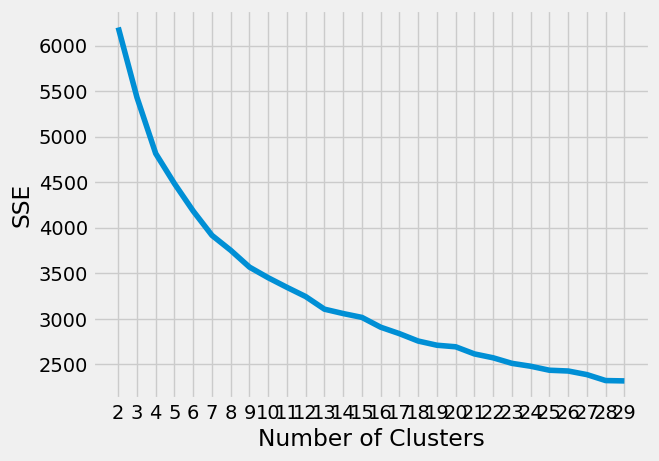

In [48]:
# Elbow curve to find optimal K 
kmeans_kwargs = {
    "init": "random",
    "n_init": 30,
    "max_iter": 300,
    "random_state": 42,
}

sse = []
silhouette_avg = {}
for k in range(2, 30):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    cluster_labels = kmeans.fit_predict(data)
    sse.append(kmeans.inertia_)
    silhouette_avg[k] = silhouette_score(data, cluster_labels)
    

print(silhouette_avg)

plt.style.use("fivethirtyeight")
plt.plot(range(2, 30), sse)
plt.xticks(range(2, 30))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()


In [49]:
kmeans = KMeans(
    init="random",
    n_clusters=9,
    n_init=30,
    max_iter=300,
    random_state=42
)
clusters = kmeans.fit_predict(data) 
clusters

array([1, 1, 1, 2, 5, 4, 4, 1, 1, 2, 0, 0, 2, 2, 4, 5, 5, 5, 3, 5, 0, 0,
       3, 7, 1, 1, 4, 3, 5, 7, 1, 5, 7, 5, 1, 5, 3, 7, 7, 3, 7, 7, 7, 7,
       5, 3, 3, 5, 7, 3, 5, 5, 5, 5, 5, 5, 5, 8, 3, 4, 7, 1, 3, 4, 3, 5,
       5, 7, 3, 8, 8, 5, 5, 3, 5, 5, 5, 5, 5, 3, 2, 3, 4, 2, 3, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 5, 3, 4, 4, 5, 2, 2, 4, 4, 4, 2, 4,
       5, 5, 5, 5, 4, 4, 1, 0, 3, 0, 4, 0, 0, 5, 5, 3, 2, 0, 3, 4, 3, 0,
       0, 0, 0, 3, 0, 5, 5, 5, 5, 5, 5, 5, 3, 3, 5, 3, 8, 8, 6, 8, 8, 8,
       6, 8, 5, 8, 3, 7, 7, 8, 6, 6, 6, 6, 8, 6, 8, 8, 8, 8, 8, 6, 8, 6,
       8, 8, 8, 8, 7, 8, 8, 7, 7, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 1, 5,
       1, 1, 4, 5, 1, 4, 4, 1, 2, 5, 5, 1, 5, 4, 5, 5, 5, 1, 5, 1, 1, 4,
       5, 2, 1, 4, 4, 3, 4, 3, 4, 3, 4, 5, 5, 3, 5, 0, 5, 3, 7, 1, 5, 1,
       7, 7, 7, 7, 7, 5, 3, 8, 8, 7, 7, 7, 7, 7, 7, 5, 7, 4, 3, 3, 3, 3,
       7, 0, 0, 0, 0, 0, 0, 3, 0, 8, 8, 7, 7, 8, 8, 8, 8, 8, 7, 7, 8, 8,
       8, 7, 7, 7, 7, 7, 7, 7, 2, 2, 2, 2, 3, 3, 0,

<Axes: >

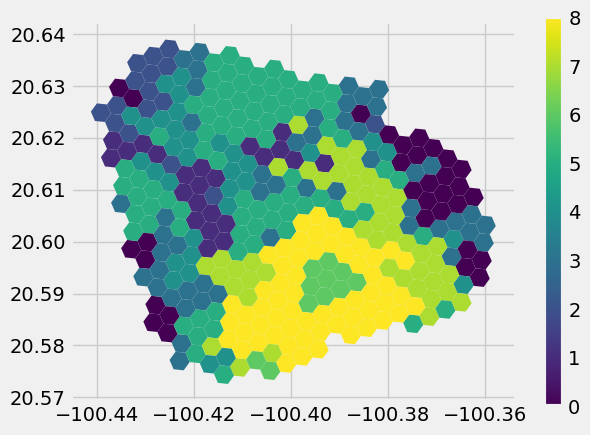

In [50]:
hex_mrg['cluster'] = clusters
hex_mrg.plot('cluster', legend=True)

In [51]:
hex_mrg.groupby('cluster').mean(numeric_only=True)

,nse_idx,graproes,dens_pob_ha,auto_viv,pct_0_17,pct_18_59,pct_60_mas,wgt_imn,denue_count,denue_jobs,...,pct_recreativomean,pct_servmean,area_in_meters,number_intersections,max_time,max_entretenimiento,max_comercio,max_servicios comunitarios,max_escuelas,idx_sum
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.219367,11.475308,53.869528,0.678264,0.278088,0.569907,0.120755,0.908935,475.289292,5682.918089,...,0.001244,0.040735,80.120345,14.357143,53.917089,42.893267,14.807964,53.425882,47.371545,9.072334
1,0.287380,12.314114,25.746419,0.631622,0.189017,0.655012,0.155971,0.968743,2451.043092,27667.579183,...,0.002946,0.192455,357.504860,4.782609,40.625466,23.971565,10.549922,39.881858,25.203966,11.806331
2,-1.101066,3.997657,0.692894,0.222311,0.476417,0.231383,0.042200,0.416124,938.654645,15966.989346,...,0.000000,0.363740,171.465430,1.333333,65.419686,33.798106,23.285640,65.419686,45.194557,8.289582
3,0.133129,11.621496,45.381251,0.627943,0.230026,0.618174,0.131392,0.943211,1645.481309,16093.197276,...,0.001477,0.079316,73.476989,12.636364,35.990611,26.912162,11.247442,33.585372,25.327040,11.657187
4,0.014773,10.430931,30.002338,0.541624,0.215280,0.574506,0.119305,0.873631,1816.641155,22596.506424,...,0.002552,0.218083,145.207273,6.857143,43.410617,26.775142,13.535162,43.281785,30.431130,11.154476
5,0.113332,11.612741,87.919185,0.600764,0.220285,0.628376,0.138993,0.964607,2667.547055,24039.258845,...,0.001681,0.103130,74.168717,18.237500,30.459902,20.848177,6.104370,26.938092,16.742342,12.754336
6,0.640788,13.450830,34.365826,0.559688,0.140313,0.624363,0.235323,0.966383,9596.235919,74195.896837,...,0.026122,0.438629,95.753605,10.181818,24.286419,11.355667,5.715417,14.730101,23.484782,13.189581
7,0.619669,13.355448,40.121982,0.741633,0.162580,0.600513,0.236908,0.970784,3837.348288,35779.776335,...,0.005672,0.306099,113.506564,10.382979,24.876170,20.001129,7.885848,20.582478,18.294890,12.883071
8,0.384767,12.423457,60.584902,0.573495,0.158452,0.605578,0.219020,0.966937,7858.256998,63754.784665,...,0.003771,0.266673,97.556787,13.271186,21.835491,13.909336,4.062839,13.513208,18.619649,13.260920


In [52]:
hex_mrg.groupby('cluster').count()

,hex_id_9,geometry,nse_idx,graproes,dens_pob_ha,auto_viv,pct_0_17,pct_18_59,pct_60_mas,wgt_imn,...,pct_recreativomean,pct_servmean,area_in_meters,number_intersections,max_time,max_entretenimiento,max_comercio,max_servicios comunitarios,max_escuelas,idx_sum
cluster,,,,,,,,,,,,,,,,,,,,,
0,32,32,32,32,32,32,32,32,32,32,...,28,28,28,28,32,32,32,32,32,32
1,23,23,23,23,23,23,23,23,23,23,...,23,23,23,23,23,23,23,23,23,23
2,16,16,16,16,16,16,16,16,16,16,...,3,3,3,3,16,16,16,16,16,16
3,49,49,49,49,49,49,49,49,49,49,...,44,44,44,44,48,48,48,48,48,48
4,33,33,33,33,33,33,33,33,33,33,...,28,28,28,28,33,33,33,33,33,33
5,81,81,81,81,81,81,81,81,81,81,...,80,80,80,80,81,81,81,81,81,81
6,11,11,11,11,11,11,11,11,11,11,...,11,11,11,11,11,11,11,11,11,11
7,47,47,47,47,47,47,47,47,47,47,...,47,47,47,47,47,47,47,47,47,47
8,59,59,59,59,59,59,59,59,59,59,...,59,59,59,59,59,59,59,59,59,59


In [53]:
hex_hm = hex_mrg.copy()
'''hex_hm = hex_hm.drop(columns=['denue_jobs_>_11','area_m2',
                               'denue_jobs','area_pob','denue_count',
                              'dens_pob_ha','wgt_imn','pct_jobs_>_11'])'''
hex_hm = hex_hm.groupby('cluster').mean(numeric_only=True)
# hex_hm = hex_hm.reset_index()

In [54]:
hex_hm.head(2)

,nse_idx,graproes,dens_pob_ha,auto_viv,pct_0_17,pct_18_59,pct_60_mas,wgt_imn,denue_count,denue_jobs,...,pct_recreativomean,pct_servmean,area_in_meters,number_intersections,max_time,max_entretenimiento,max_comercio,max_servicios comunitarios,max_escuelas,idx_sum
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.219367,11.475308,53.869528,0.678264,0.278088,0.569907,0.120755,0.908935,475.289292,5682.918089,...,0.001244,0.040735,80.120345,14.357143,53.917089,42.893267,14.807964,53.425882,47.371545,9.072334
1,0.287380,12.314114,25.746419,0.631622,0.189017,0.655012,0.155971,0.968743,2451.043092,27667.579183,...,0.002946,0.192455,357.504860,4.782609,40.625466,23.971565,10.549922,39.881858,25.203966,11.806331


In [55]:
scaler = StandardScaler()
scaled_cluster = scaler.fit_transform(hex_hm)

In [61]:
hex_hm.mean(axis=0)

nse_idx                           0.145793
graproes                         11.186887
dens_pob_ha                      42.076036
auto_viv                          0.575261
pct_0_17                          0.230051
pct_18_59                         0.567535
pct_60_mas                        0.155541
wgt_imn                           0.886595
denue_count                    3476.277528
denue_jobs                    31752.989667
denue_jobs_>_11               20765.645232
pct_jobs_>_11                     0.687116
pct_BANQUETA                      0.816996
pct_ALUMPUB                       0.592157
pct_RAMPAS                        0.200619
pct_ARBOLES                       0.534676
pct_CICLOVIA                      0.030611
ndvi_mean                         0.147223
temp_diff_mean                    0.299272
area_m2                       16739.419271
pct_openspace                     0.616887
street_dens                       0.692783
pct_comerciomean                  0.138163
pct_equipme

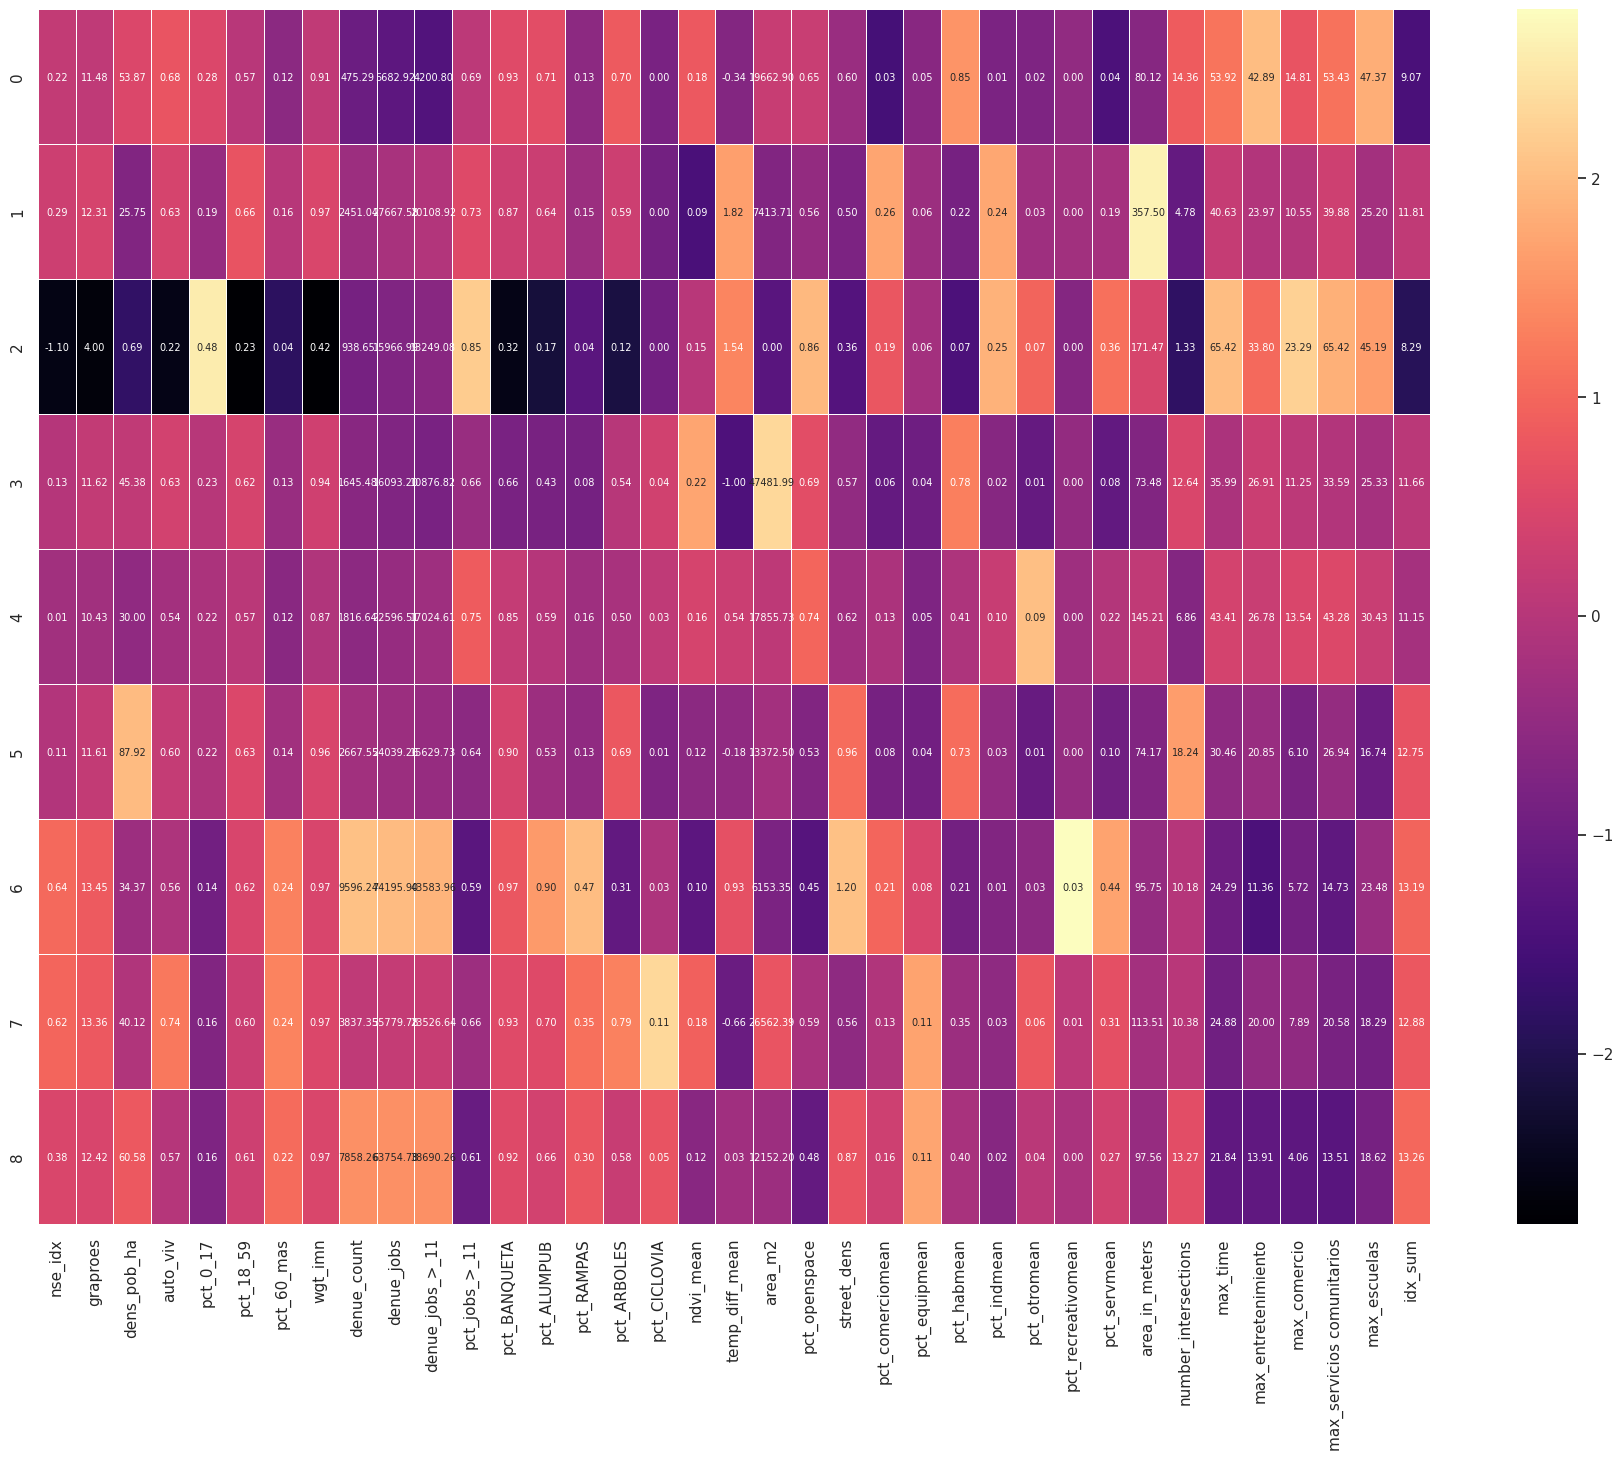

In [56]:
sns.set (rc = {'figure.figsize':(20,15)})

sns.heatmap(scaled_cluster, annot=hex_hm, 
            xticklabels=hex_hm.columns,
           fmt=".2f", linewidth=.5, cmap="magma",
           annot_kws={'size': 7})

plt.savefig('../../../output/figures/Distrito_QRO/Clusters_Statistical_Behaviour.png')

In [57]:
hex_mrg.to_file(f'{data_dir}hex_clusters.geojson')